In [1]:
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

from datatype_recovery.models.dataset import load_dataset_from_path

def plot_prefilter_variables(var_df:pd.DataFrame):
    '''
    Plot the kinds of variables before filtering
    (<Component>, Local/Param, Return Type) since we will be potentially filtering
    out the component and return types
    '''
    ax = (var_df.groupby('Label').count()/len(var_df)*100).BinaryId.plot(kind='bar', rot=0)
    ax.set_title('Variables (before filtering)')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', label_type='center', color='white')
    plt.show()

def prefilter(var_df:pd.DataFrame, drop_comp:bool, drop_return_types:bool) -> pd.DataFrame:
    '''
    Compute the initial variable balance, plot the balance, and drop the
    desired variables returning the resulting data frame
    '''
    # show initial balance here
    var_df.loc[var_df.TypeSeq_Debug=='COMP','Label'] = '<Component>'
    var_df.loc[var_df.IsReturnType_Debug, 'Label'] = 'Return Type'
    var_df.Label = var_df.Label.fillna('Local/Param')

    plot_prefilter_variables(var_df)

    filter_df = var_df
    if drop_comp:
        filter_df = filter_df.loc[filter_df.TypeSeq_Debug!='COMP']
    if drop_return_types:
        filter_df = filter_df.loc[~filter_df.IsReturnType_Debug, :]
    return filter_df

def plot_locals_vs_params(var_df:pd.DataFrame, title_suffix:str=''):
    ax = (var_df.groupby('Vartype').count()/len(var_df)*100).BinaryId.rename({'l': 'Local', 'p': 'Param'}).plot(kind='bar', rot=0)
    ax.set_title(f'Variable Kinds{title_suffix}')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', label_type='edge', color='black')
    ax.grid(False)
    sns.despine()
    plt.show()

def compute_datatype_class_balance(var_df:pd.DataFrame) -> pd.DataFrame:
    '''
    Compute the datatype class balance of the dataset and return a DataFrame
    where each data type class is a row, and each column corresponds to a type sequence
    length (only one column/row combo has a value, the others are NaN).

    This layout allows plotting the balance and coloring by type sequence length
    '''
    dt_classes = var_df.groupby('TypeSeq_Debug').count()[['BinaryId']]
    dt_classes['TypeSeqLen'] = [len(x.split(',')) for x in dt_classes.index]

    order_idx = sorted(dt_classes.index, key=lambda x: f'{len(x.split(","))}{x}')
    bal_df = dt_classes.pivot(columns='TypeSeqLen', values='BinaryId').loc[order_idx]/len(var_df)*100
    return bal_df

def plot_typeseq_len(bal_df:pd.DataFrame):
    ax = bal_df.sum().plot(kind='bar', rot=0)
    ax.set_title('Type Sequence Length')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', label_type='edge', color='black')
    ax.grid(False)
    sns.despine()
    plt.show()

def plot_full_dataset_balance(bal_df:pd.DataFrame, title_suffix:str=''):
    ax = bal_df.plot(kind='bar', stacked=True, figsize=(18, 9))
    ax.set_title(f'Data Type Balance{title_suffix}')
    ax.set_ylabel('Percentage (%)')
    ax.set_xlabel('')
    # ax.set_ylim([0, 0.025])
    for container in ax.containers:
        ax.bar_label(container, label_type='edge', fmt=lambda x: f'{x:.2f}%' if x > 5 else '')
    ax.grid(False)
    sns.despine()
    plt.show()

def plot_dataset_balance(dataset_path:Path, drop_comp:bool, drop_return_types:bool):
    '''
    Plot the balance of the dataset
    '''
    dataset = load_dataset_from_path(dataset_path)
    var_df = dataset.read_vars_csv()
    var_df = prefilter(var_df, drop_comp, drop_return_types)
    plot_locals_vs_params(var_df, title_suffix=' (after filtering)')

    bal_df = compute_datatype_class_balance(var_df)
    plot_typeseq_len(bal_df)
    plot_full_dataset_balance(bal_df, f' ({len(var_df):,} total vars)')

    # TODO:
    # plt.savefig('type_seq_len.png')

    return var_df, bal_df


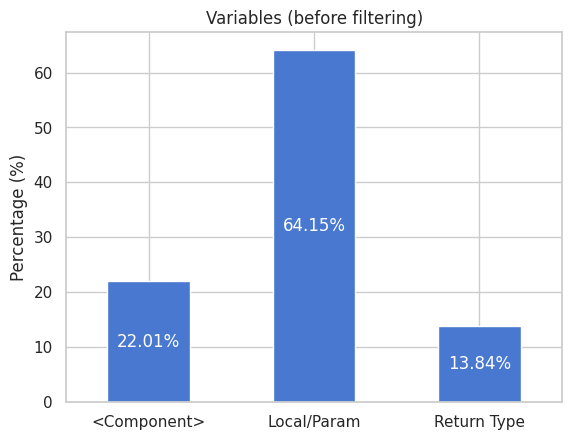

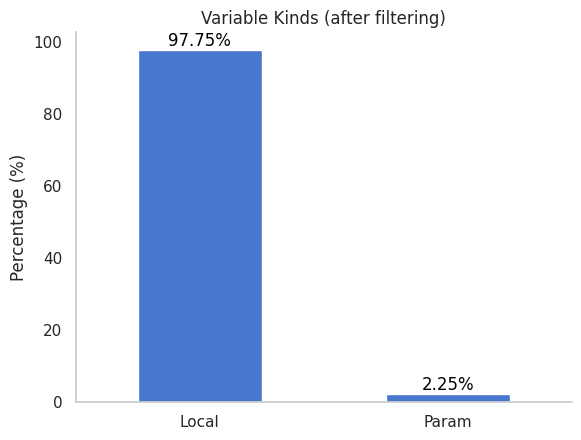

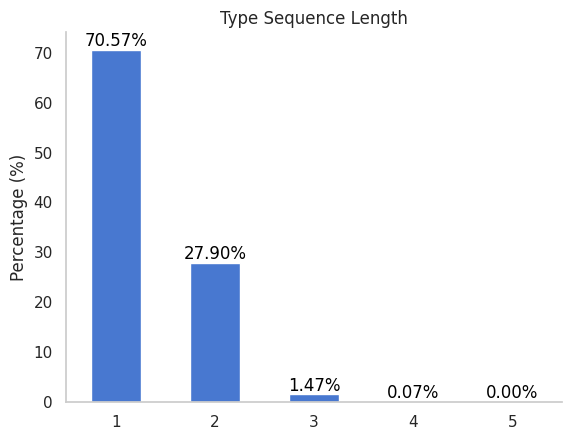

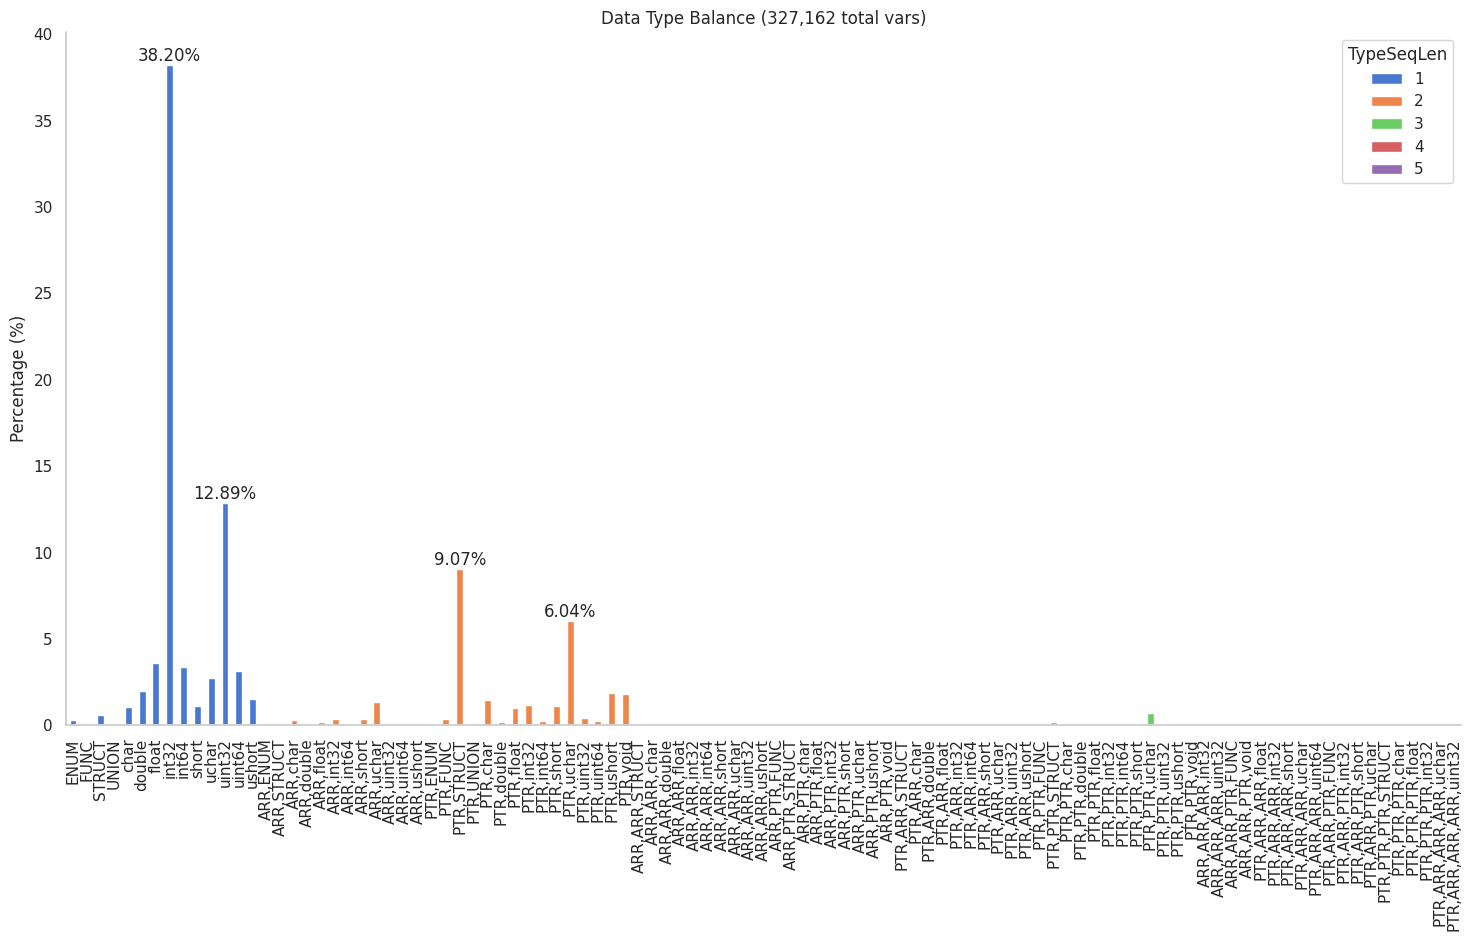

In [2]:
# ----------------------------------------------------------
# parameters
dataset_path = Path.home()/'datasets/trainset_astera_ffmpeg'
# dataset_path = Path.home()/'datasets/trainset_astera_full_5hops_nocomp'
drop_comp = True
drop_return_types = True    # right now TypeSeqDatset is doing this
# ----------------------------------------------------------

# context: talk, notebook, paper, poster
# palette: muted, Paired, hls, husl, pastel, bright, deep, dark, colorblind
sns.set_theme(style='whitegrid', context='notebook', palette='muted')

var_df, bal_df = plot_dataset_balance(dataset_path, drop_comp, drop_return_types)

In [3]:
[(bal_df.index[i], val) for i, val in enumerate(bal_df.sum(axis=1))]

# bal_df[~bal_df[1].isna()]
lookup = {}
for i in range(1, bal_df.columns.max()+1):
    lookup[str(i)] = [(bal_df.index[i], val) for i, val in enumerate(bal_df[i])]
lookup.keys()

dict_keys(['1', '2', '3', '4', '5'])

In [4]:
#plot_typeseq_len(bal_df)
#plot_full_dataset_balance(bal_df)
test = bal_df*len(var_df)
var_df.groupby('TypeSeq_Debug').count()[['BinaryId']].sort_values('BinaryId')

from datatype_recovery.models.dataset.encoding import TypeSequence

# keep all 1-element sequences, apply the projection from 2-element sequences and up

projection_1stlevel = {
    'int128': 'int64',      # don't worry about ensuring int128 is in our train set
    'uint128': 'uint64',
    'uint256': 'uint64',
    'uint512': 'uint64',
    # these don't occur in isolation
    'PTR': 'signed_int',
    'ARR': 'signed_int',
    'void': 'signed_int',
}

projection_2ndlevel = {
    'long double': 'double',
    'char': 'signed_int',
    'short': 'signed_int',
    'int32': 'signed_int',
    'int64': 'signed_int',
    'int128': 'signed_int',
    'uchar': 'unsigned_int',
    'ushort': 'unsigned_int',
    'uint32': 'unsigned_int',
    'uint64': 'unsigned_int',
    'uint128': 'unsigned_int',
    'uint256': 'unsigned_int',
    'uint512': 'unsigned_int',
    'UNION': 'STRUCT',  # group in with struct
    'ENUM': 'unsigned_int',
}

projection = {
    1: projection_1stlevel,
    2: projection_2ndlevel,
}

# maybe exclude void from consideration after 2-seq?

valid_sequences = TypeSequence().valid_type_sequences_for_len(3)

from typing import List, Dict

def project_typesequence(tseq:List[str], projection:Dict, drop_after_len:int=None) -> List[str]:
    '''
    tseq: Sequence to be converted
    projection: Maps seqlen -> type name remapping; for each seqlen, its remap is
                used to convert any keys appearing in the sequence to the values they
                are mapped to.

                Keys not appearing are left alone.
                Sequence lengths not appearing in projection are left alone.

    CLS: gotta be a better way of doing this, but it's getting late and I
    just need it done, so python-smashing my way to victory :)
    '''
    seqlen = len(tseq)

    trunc_seq = tseq[:drop_after_len] if drop_after_len is not None else tseq

    if seqlen in projection:
        return [projection[seqlen][x] if x in projection[seqlen] else x for x in trunc_seq]
    return trunc_seq     # no mapping for this sequence length


    # if len(seq) > 1:
    #     projected_seq.append([projection_2ndlevel[x] if x in projection_2ndlevel else x for x in seq])
    # else:
    #     projected_seq.append([projection_1stlevel[x] if x in projection_1stlevel else x for x in seq])


# sorted(list(x.split(',') for x in set(",".join(x) for x in projected_seq)), key=lambda x: f'{len(x)}{",".join(x)}')
projected_seq = [project_typesequence(s, projection) for s in valid_sequences]
projected_seq

var_df.TypeSeq_Debug
var_df['Projection'] = var_df.TypeSeq_Debug.apply(lambda x: ",".join(project_typesequence(x.split(','), projection, drop_after_len=2)))

In [67]:
var_df = var_df.loc[var_df.TypeSeq_Debug!='FUNC',:]

In [69]:
#len(set(",".join(x) for x in projected_seq))
proj_classes = var_df.groupby('Projection').count()[['BinaryId']].index.to_list()

all_proj_classes = set([",".join(x) for x in projected_seq])

len(all_proj_classes)

all_proj_classes - set(proj_classes)
min_value = var_df.groupby('Projection').count().BinaryId.sort_values().iloc[0]
print(f'Balance with {min_value} samples per class')

var_df.groupby('Projection').count().BinaryId.sort_values()

Balance with 78 samples per class


Projection
UNION                   78
ARR,double              88
ARR,STRUCT             107
ARR,PTR                250
ARR,ARR                288
ARR,float              625
PTR,double             719
PTR,ARR                877
ENUM                  1014
PTR,FUNC              1117
STRUCT                1942
PTR,float             3355
char                  3524
ARR,signed_int        3565
PTR,PTR               3618
short                 3618
ARR,unsigned_int      4879
ushort                4960
PTR,void              5941
double                6502
uchar                 9006
uint64               10343
int64                11011
float                11705
PTR,signed_int       13043
PTR,unsigned_int     28112
PTR,STRUCT           29715
uint32               42185
int32               124973
Name: BinaryId, dtype: int64

In [81]:
balanced_df = var_df.groupby('Projection').sample(n=min_value, random_state=33)
percent_dropped = 100-len(balanced_df)/len(var_df)*100
print(f'Dropped {percent_dropped:.2f}% of the original dataset (from {len(var_df):,} down to {len(balanced_df):,})')


Dropped 99.31% of the original dataset (from 327,160 down to 2,262)


In [85]:
balanced_df
dataset = load_dataset_from_path(dataset_path)
dataset

InMemTypeSequenceDataset(327162)

In [87]:
dataset[0].varid

(1000, 6828399, '274,345,375', 'l')

In [98]:
balanced_df['VarID'] = balanced_df.apply(lambda x: (x.BinaryId, x.FunctionStart, x.Signature, x.Vartype), axis=1)

In [119]:
balanced_varids = balanced_df.VarID.to_list()

balanced_indices = [i for i in range(len(dataset)) if dataset[i].varid in balanced_varids]
balanced_indices

[126,
 1123,
 1259,
 1466,
 1539,
 1575,
 1609,
 1750,
 1930,
 1968,
 2005,
 2076,
 2126,
 2154,
 2189,
 2429,
 2454,
 2531,
 2560,
 2561,
 2621,
 2807,
 2912,
 2922,
 2999,
 3001,
 3020,
 3093,
 3117,
 3187,
 3288,
 3421,
 3562,
 3601,
 3647,
 3783,
 4080,
 4121,
 4219,
 4240,
 4241,
 4347,
 4466,
 4503,
 4574,
 4575,
 4895,
 4948,
 5059,
 5060,
 5248,
 5262,
 5263,
 5459,
 5720,
 5750,
 5767,
 5937,
 5979,
 5986,
 5987,
 6009,
 6066,
 6105,
 6181,
 6286,
 6340,
 6624,
 6752,
 6852,
 6919,
 6962,
 7023,
 7061,
 7102,
 7175,
 7266,
 7382,
 7526,
 7634,
 7635,
 7695,
 7810,
 7815,
 7929,
 8123,
 8262,
 8379,
 8544,
 8596,
 8649,
 8664,
 8809,
 8837,
 8905,
 9278,
 9368,
 9460,
 9863,
 9936,
 9994,
 10163,
 10187,
 10500,
 10510,
 10534,
 10538,
 10823,
 10884,
 11055,
 11102,
 11451,
 11510,
 11723,
 11957,
 12072,
 12073,
 12594,
 12699,
 12895,
 12927,
 12930,
 13028,
 13036,
 13861,
 14034,
 14532,
 14626,
 14692,
 14705,
 14780,
 14809,
 15119,
 15197,
 15346,
 15566,
 16074,
 16137

<Axes: xlabel='TypeSeq_Debug'>

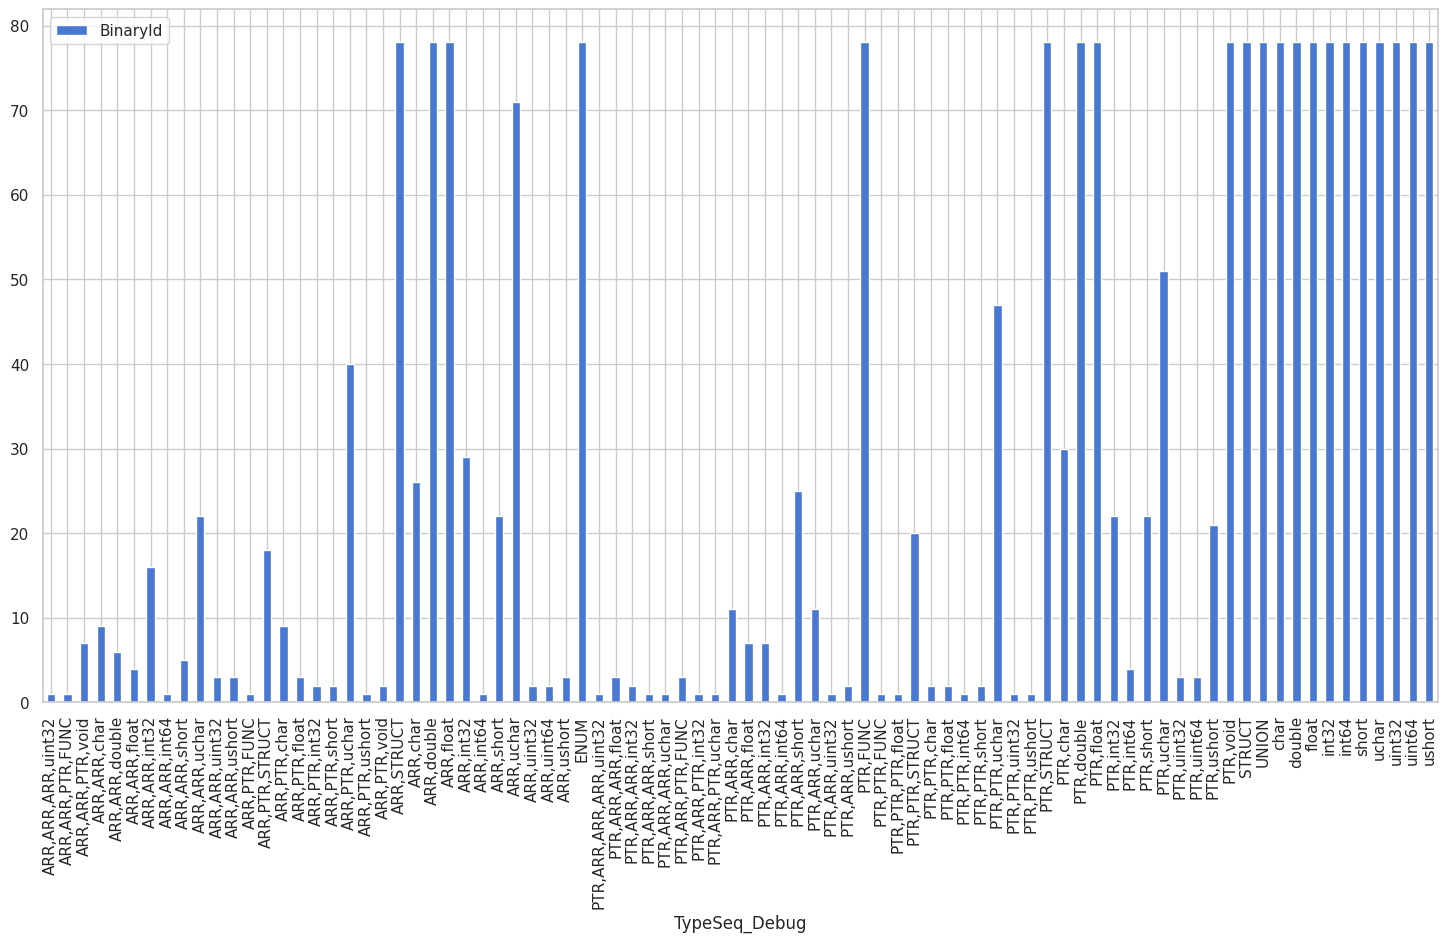

In [126]:
balanced_df.groupby('TypeSeq_Debug').count()[['BinaryId']].plot(kind='bar', figsize=(18,9))

In [73]:
balanced_df.groupby('Projection').count()[['BinaryId']]

,BinaryId
Projection,
"ARR,ARR",78
"ARR,PTR",78
"ARR,STRUCT",78
"ARR,double",78
"ARR,float",78
"ARR,signed_int",78
"ARR,unsigned_int",78
ENUM,78
"PTR,ARR",78


In [9]:
for i in range(1, 5):
    print(f'{len(TypeSequence().valid_type_sequences_for_len(i))} valid types for sequence of length {i}')

18 valid types for sequence of length 1
56 valid types for sequence of length 2
132 valid types for sequence of length 3
284 valid types for sequence of length 4


In [26]:
max_seq_len = 4
num_over_maxlen = counts[counts.TypeSeqLen>max_seq_len].BinaryId.sum()
print(f'{num_over_maxlen:,} of {len(var_df):,} variables exceeded max length of {max_seq_len} ({num_over_maxlen/len(var_df)*100:.3f}%)')

12 of 327,162 variables exceeded max length of 4 (0.004%)


In [9]:
var_df.loc[:,'TSL_Debug'] = var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(',')))
var_df[(var_df.HasDWARF)&(var_df.TSL_Debug<=1)].groupby('TypeSeq_Debug').count().sort_values('BinaryId')

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,LocOffset_Debug,TypeCategory_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,Label,TSL_Debug
TypeSeq_Debug,,,,,,,,,,,,,,,,,,,,,
UNION,31,31,31,31,31,0,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
short,132,132,132,132,132,15,132,132,132,132,...,132,132,132,132,132,132,132,132,132,132
char,178,178,178,178,178,46,178,178,178,178,...,178,178,178,178,178,178,178,178,178,178
ushort,295,295,295,295,295,30,295,295,295,295,...,295,295,295,295,295,295,295,295,295,295
ENUM,331,331,331,331,331,20,331,331,331,331,...,331,331,331,331,331,331,331,331,331,331
uchar,723,723,723,723,723,157,723,723,723,723,...,723,723,723,723,723,723,723,723,723,723
STRUCT,1590,1590,1590,1590,1590,0,1590,1590,1590,1590,...,1590,1590,1590,1590,1590,1590,1590,1590,1590,1590
uint64,1601,1601,1601,1601,1601,4,1601,1601,1601,1601,...,1601,1601,1601,1601,1601,1601,1601,1601,1601,1601
double,1726,1726,1726,1726,1726,6,1726,1726,1726,1726,...,1726,1726,1726,1726,1726,1726,1726,1726,1726,1726


In [10]:
ordered_idx = sorted(counts.index, key=lambda x: f'{len(x.split(","))}{x}')
max_true_len = var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(','))).max()
var_df[var_df.TypeSeq_Debug.apply(lambda ts: len(ts.split(',')) >= 5)]

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,Label,TSL_Debug
65754,25841056,"146,1263,1853,25...",lVar19,int64,register,rax,0.0,BUILTIN,int64,paaauVar18,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
65755,25841056,"259,1263,1853,25...",lVar20,int64,register,rax,0.0,BUILTIN,int64,paaauVar19,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
65756,25841056,"352,1263,1853,25...",lVar21,int64,register,rax,0.0,BUILTIN,int64,paaauVar20,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
65785,25848723,"146,1263,1853,25...",lVar19,int64,register,rax,0.0,BUILTIN,int64,paaauVar18,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
65786,25848723,"259,1263,1853,25...",lVar20,int64,register,rax,0.0,BUILTIN,int64,paaauVar19,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
65787,25848723,"352,1263,1853,25...",lVar21,int64,register,rax,0.0,BUILTIN,int64,paaauVar20,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1000,l,False,False,Local/Param,5
267074,26099504,"146,1263,1853,25...",lVar19,int64,register,rax,0.0,BUILTIN,int64,paaauVar18,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1001,l,False,False,Local/Param,5
267075,26099504,"259,1263,1853,25...",lVar20,int64,register,rax,0.0,BUILTIN,int64,paaauVar19,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1001,l,False,False,Local/Param,5
267076,26099504,"352,1263,1853,25...",lVar21,int64,register,rax,0.0,BUILTIN,int64,paaauVar20,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1001,l,False,False,Local/Param,5
267105,26107171,"146,1263,1853,25...",lVar19,int64,register,rax,0.0,BUILTIN,int64,paaauVar18,...,PTR,"PTR,ARR,ARR,ARR,...",False,"{""kind"": ""Pointe...",1001,l,False,False,Local/Param,5


<Axes: xlabel='TypeSeq_Debug'>

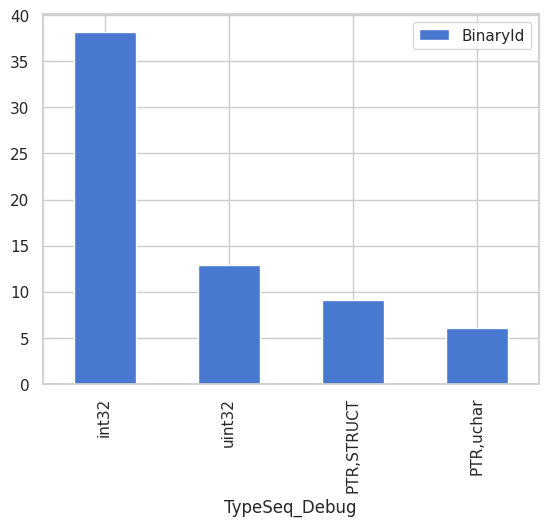

In [30]:
perc_df = (counts.loc[ordered_idx][['BinaryId']]/len(var_df)*100)
# .plot(kind='bar')
perc_df[perc_df.BinaryId>=4].plot(kind='bar')

In [12]:
perc_df.sort_values('BinaryId')

,BinaryId
TypeSeq_Debug,
FUNC,0.000611
"ARR,PTR,FUNC",0.000611
"ARR,PTR,int32",0.000611
"ARR,ARR,PTR,FUNC",0.000611
"ARR,ARR,ARR,uint32",0.000611
...,...
float,3.577738
"PTR,uchar",6.035542
"PTR,STRUCT",9.072264


In [13]:
var_df[var_df.TypeSeq_Debug=='FUNC']

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,Label,TSL_Debug
197434,16584249,"3058,3138,3173,3204",bVar3,uchar,register,al,0.0,BUILTIN,uchar,cVar2,...,FUNC,FUNC,False,"{""kind"": ""Functi...",1000,l,False,False,Local/Param,1
199640,16842697,"3058,3138,3173,3204",bVar3,uchar,register,al,0.0,BUILTIN,uchar,cVar2,...,FUNC,FUNC,False,"{""kind"": ""Functi...",1001,l,False,False,Local/Param,1


In [14]:
# TODO: normalize Ghidra's FUNC var types to be PTR,FUNC for consistency

from varlib.datatype import datatype_from_json_str, PointerType

ftype = datatype_from_json_str(var_df[var_df.TypeSeq_Debug=='FUNC'].TypeJson_Debug.iloc[0])
ftype
PointerType(ftype, pointer_size=8)

int32 (*code)()